In [67]:
# test image
test_image_1 = 'resized_images_100x100/ApurtranTablet150mg(Irbesartan)_crop_0_0_resized.jpg' 
test_bbox_1 = 'resized_images_100x100/ApurtranTablet150mg(Irbesartan)_crop_0_0_resized.txt'  

test_image_2 = 'padded_images/padded_ApurtranTablet150mg(Irbesartan)_crop_0_0_resized.jpg' 
test_bbox_2 = 'padded_images/padded_ApurtranTablet150mg(Irbesartan)_crop_0_0_resized.txt'  

# Image Augmentation

1. Image resize

In [8]:
import cv2
import os

def resize_image_with_aspect_ratio_and_adjust_bboxes(image_path, bbox_path, output_folder, target_size=(100, 100)):
    # 이미지 읽기
    image = cv2.imread(image_path)
    h, w, _ = image.shape

    # 비율 유지하며 이미지 리사이즈
    scale = min(target_size[0] / h, target_size[1] / w)
    new_w = int(w * scale)
    new_h = int(h * scale)

    resized_image = cv2.resize(image, (new_w, new_h))

    # 패딩 추가하여 target_size에 맞추기
    delta_w = target_size[1] - new_w
    delta_h = target_size[0] - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = [0, 0, 0]  # 검은색 패딩
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    # 바운딩 박스 읽기 (YOLO 형식)
    bboxes = []
    with open(bbox_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            label = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])

            # 기존 바운딩 박스 좌표를 리사이즈된 이미지에 맞게 조정
            new_x_center = (x_center * w * scale + left) / target_size[1]
            new_y_center = (y_center * h * scale + top) / target_size[0]
            new_width = width * scale * (w / target_size[1])  # 바운딩 박스 크기도 리사이즈
            new_height = height * scale * (h / target_size[0])

            bboxes.append([label, new_x_center, new_y_center, new_width, new_height])

    # 리사이즈된 이미지 저장 경로
    resized_image_path = os.path.join(output_folder, os.path.splitext(os.path.basename(image_path))[0] + '_resized.jpg')
    cv2.imwrite(resized_image_path, padded_image)

    # 조정된 바운딩 박스 저장 경로
    resized_bbox_path = os.path.join(output_folder, os.path.splitext(os.path.basename(bbox_path))[0] + '_resized.txt')
    with open(resized_bbox_path, 'w') as file:
        for bbox in bboxes:
            file.write(f"{bbox[0]} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f} {bbox[4]:.6f}\n")

    return resized_image_path, resized_bbox_path

# 예시 경로
data_path = 'cropped_images2/'  # 데이터가 있는 디렉토리 경로
output_folder = 'resized_images_100x100'  # 이미지를 저장할 경로

# 출력 폴더가 없으면 생성
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 데이터 디렉토리 내 모든 파일에 대해 처리
image_extensions = ('.jpg', '.jpeg', '.png')  # 지원하는 이미지 파일 확장자
for filename in os.listdir(data_path):
    if filename.endswith(image_extensions):
        image_path = os.path.join(data_path, filename)
        bbox_path = os.path.splitext(image_path)[0] + '.txt'  # 동일한 이름의 바운딩 박스 파일

        if os.path.exists(bbox_path):
            resize_image_with_aspect_ratio_and_adjust_bboxes(image_path, bbox_path, output_folder, target_size=(100, 100))
            print(f"Resized image and bounding box saved for {image_path}")
        else:
            print(f"Bounding box file not found for {image_path}")


Resized image and bounding box saved for cropped_images2/GasridTablet5mg(MosaprideCitrateHydrate)_crop_10_1.jpg
Resized image and bounding box saved for cropped_images2/GasridTablet5mg(MosaprideCitrateHydrate)_crop_10_0.jpg
Resized image and bounding box saved for cropped_images2/GasbetTablet5mg(MosaprideCitrateHydrate)_crop_7_0.jpg
Resized image and bounding box saved for cropped_images2/RosorodTablet10mg(RosuvastatinCalcium)_crop_13_0.jpg
Resized image and bounding box saved for cropped_images2/LipinonTablet80mg(AtorvastatinCalciumTrihydrate)_crop_11_1.jpg
Resized image and bounding box saved for cropped_images2/LipinonTablet80mg(AtorvastatinCalciumTrihydrate)_crop_11_0.jpg
Resized image and bounding box saved for cropped_images2/RosorodTablet10mg(RosuvastatinCalcium)_crop_13_1.jpg
Resized image and bounding box saved for cropped_images2/GasbetTablet5mg(MosaprideCitrateHydrate)_crop_7_1.jpg
Resized image and bounding box saved for cropped_images2/GasdialTablet50mg(DimethiconeMagnesiu

### Check Image bbox 

In [68]:
import cv2
import os

def draw_bboxes(image_path, bbox_path, output_path=None):
    # 이미지 읽기
    image = cv2.imread(image_path)
    h, w, _ = image.shape
    
    # 바운딩 박스 읽기 (YOLO 형식)
    with open(bbox_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            label = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])
            
            # YOLO 형식의 바운딩 박스를 픽셀 좌표로 변환
            x1 = int((x_center - width / 2) * w)
            y1 = int((y_center - height / 2) * h)
            x2 = int((x_center + width / 2) * w)
            y2 = int((y_center + height / 2) * h)
            
            # 바운딩 박스 그리기 (색상은 랜덤으로 지정)
            color = (0, 255, 0)  # 초록색 바운딩 박스
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            cv2.putText(image, f'Label: {label}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    # 바운딩 박스가 그려진 이미지 저장 또는 출력
    if output_path:
        cv2.imwrite(output_path, image)
    else:
        cv2.imshow('Image with Bounding Boxes', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

# 사용 예시
# image_path = 'test_augmented_images/augmented_image_1.jpg'  # 실제 이미지 경로
# image_path = 'test_augmented_images/ApurtranTablet150mg(Irbesartan)_augmented_image_3.jpg'
# bbox_path = 'test_augmented_images/ApurtranTablet150mg(Irbesartan)_augmented_image_3.txt'     # 실제 YOLO 형식의 바운딩 박스 파일 경로
image_path = test_image_2
bbox_path = test_bbox_2
output_image_path = 'image_with_bboxes_test12.jpg'  # 결과 이미지를 저장할 경로

draw_bboxes(image_path, bbox_path, output_image_path)


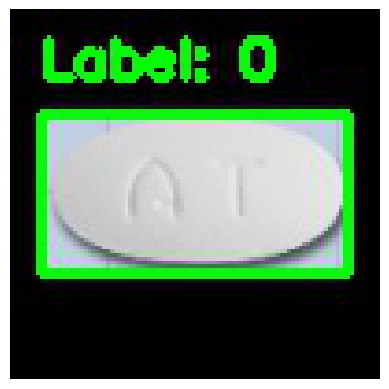

In [69]:
import cv2
import matplotlib.pyplot as plt

def show_image(image_path):
    # 이미지 읽기
    image = cv2.imread(image_path)
    
    # BGR을 RGB로 변환
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # 이미지 표시
    plt.imshow(image_rgb)
    plt.axis('off')  # 축 숨기기
    plt.show()

# 예시 경로
image_path = 'image_with_bboxes_test12.jpg'  # 확인할 이미지 경로
show_image(image_path)


In [45]:
# 이미지 경로와 바운딩 박스 경로 및 저장 경로 설정
input_folder = 'resized_images_100x100'
output_folder = 'padded_images'

# 출력 폴더가 없으면 생성
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# input_folder 내의 모든 이미지 파일에 대해 반복
for file_name in os.listdir(input_folder):
    if file_name.endswith('.jpg') or file_name.endswith('.png'):  # 지원하는 이미지 형식
        # 이미지 경로 및 바운딩 박스 경로 설정
        image_path = os.path.join(input_folder, file_name)
        bbox_path = os.path.splitext(image_path)[0] + '.txt'  # 동일한 이름의 .txt 파일 경로

        # 이미지를 읽기
        image = cv2.imread(image_path)

        # 이미지가 제대로 읽혔는지 확인
        if image is None:
            print(f"이미지를 읽을 수 없습니다: {file_name}")
            continue

        # YOLO 형식의 바운딩 박스 읽기
        bboxes = []
        with open(bbox_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                parts = line.strip().split()
                label = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:])
                bboxes.append([label, x_center, y_center, width, height])  # [label, x_center, y_center, width, height]

        # 원하는 패딩 크기 설정
        top, bottom, left, right = 10, 10, 10, 10  # 각 방향의 패딩 두께

        # 이미지에 패딩 추가 (검은색으로)
        padded_image = cv2.copyMakeBorder(
            image, 
            top, 
            bottom, 
            left, 
            right, 
            cv2.BORDER_CONSTANT, 
            value=[0, 0, 0]  # 검은색 패딩
        )

        # 패딩이 추가된 이미지 크기
        padded_height, padded_width = padded_image.shape[:2]

        # 바운딩 박스 업데이트
        updated_bboxes = []
        for bbox in bboxes:
            label, x_center, y_center, width, height = bbox

            # 패딩을 고려하여 새로운 중심 좌표 계산
            x_center_padded = (x_center * image.shape[1] + left) / padded_width
            y_center_padded = (y_center * image.shape[0] + top) / padded_height
            width_padded = width * image.shape[1] / padded_width
            height_padded = height * image.shape[0] / padded_height

            # 업데이트된 바운딩 박스를 리스트에 추가
            updated_bboxes.append([label, x_center_padded, y_center_padded, width_padded, height_padded])

        # 패딩이 추가된 이미지 크기를 100x100으로 조정
        resized_image = cv2.resize(padded_image, (100, 100))

        # 패딩이 추가된 이미지 저장
        output_image_path = os.path.join(output_folder, f'padded_{file_name}')
        cv2.imwrite(output_image_path, resized_image)

        # 업데이트된 바운딩 박스 저장
        output_bbox_path = os.path.join(output_folder, f'padded_{os.path.splitext(file_name)[0]}.txt')
        with open(output_bbox_path, 'w') as f:
            for bbox in updated_bboxes:
                f.write(f"{int(bbox[0])} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f} {bbox[4]:.6f}\n")

        print(f"패딩이 추가된 이미지와 업데이트된 바운딩 박스가 저장되었습니다: {output_image_path}")


패딩이 추가된 이미지와 업데이트된 바운딩 박스가 저장되었습니다: padded_images/padded_GasbetTablet5mg(MosaprideCitrateHydrate)_crop_7_1_resized.jpg
패딩이 추가된 이미지와 업데이트된 바운딩 박스가 저장되었습니다: padded_images/padded_NumentaminSustainedReleaseCapsule8mg(GalantamineBromide)_crop_12_1_resized.jpg
패딩이 추가된 이미지와 업데이트된 바운딩 박스가 저장되었습니다: padded_images/padded_GasprenTablet(MosaprideCitrateDihydrate)_crop_9_1_resized.jpg
패딩이 추가된 이미지와 업데이트된 바운딩 박스가 저장되었습니다: padded_images/padded_GasridTablet5mg(MosaprideCitrateHydrate)_crop_10_0_resized.jpg
패딩이 추가된 이미지와 업데이트된 바운딩 박스가 저장되었습니다: padded_images/padded_ValsartanTablet(Valsartan)_crop_16_0_resized.jpg
패딩이 추가된 이미지와 업데이트된 바운딩 박스가 저장되었습니다: padded_images/padded_EscitalTablet5mg(EscitalopramOxalate)_crop_4_1_resized.jpg
패딩이 추가된 이미지와 업데이트된 바운딩 박스가 저장되었습니다: padded_images/padded_BalsanTablet80mg(Valsartan)_crop_1_1_resized.jpg
패딩이 추가된 이미지와 업데이트된 바운딩 박스가 저장되었습니다: padded_images/padded_ValsartelTablet160mg(Valsartan)_crop_17_0_resized.jpg
패딩이 추가된 이미지와 업데이트된 바운딩 박스가 저장되었습니다: padded_images/padded_BalthrepTa

### Image Augmentation with Imgaug

In [56]:
import imgaug.augmenters as iaa
import imgaug as ia


# # 이미지 경로와 저장 경로 설정
# image_path = 'resized_images_100x100/ApurtranTablet150mg(Irbesartan)_crop_0_0_resized.jpg'  # 실제 이미지 경로
# bbox_path = 'resized_images_100x100/ApurtranTablet150mg(Irbesartan)_crop_0_0_resized.txt'  
# output_folder = 'test_augmented_images'

# 바운딩 박스를 imgaug 형식으로 변환
def convert_to_imgaug_format(bboxes, image_shape):
    bbs = []
    for bbox in bboxes:
        label, x_center, y_center, width, height = bbox
        # YOLO 형식 -> imgaug 형식 변환
        x1 = (x_center - width / 2) * image_shape[1]
        y1 = (y_center - height / 2) * image_shape[0]
        x2 = (x_center + width / 2) * image_shape[1]
        y2 = (y_center + height / 2) * image_shape[0]
        bbs.append(ia.BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2, label=label))
    return ia.BoundingBoxesOnImage(bbs, shape=image_shape)

def imgaug_randomly(image_path, bbox_path, num_of_image, output_folder='test_augmented_images'):
    # 출력 폴더가 없으면 생성
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # 이미지를 읽고 크기를 조정
    image = cv2.imread(image_path)
    image = cv2.resize(image, (120, 120))  # 원하는 크기로 조정

    file_name = os.path.basename(image_path)

    # 파일 이름에서 필요한 부분만 남기기
    name_part = file_name.split('_crop')[0]

    # YOLO 형식의 바운딩 박스 읽기
    bboxes = []
    with open(bbox_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            label = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])
            bboxes.append([label, x_center, y_center, width, height])  # [label, x_center, y_center, width, height]

    # imgaug를 사용하여 증강 기법 정의
    seq = iaa.Sequential([
        # iaa.Fliplr(0.5),  # 수평 반전
        iaa.Affine(rotate=(-30, 30)),  # -30도에서 30도 사이로 회전
        iaa.AdditiveGaussianNoise(scale=(0, 0.1*255)),  # 가우시안 노이즈 추가
        iaa.Multiply((0.8, 1.2)),  # 밝기 조정
        iaa.ContrastNormalization((0.5, 2.0)),  # 대비 조정
        # iaa.Crop(percent=(0, 0.1)),  # 0%에서 10%까지 잘라내기
        iaa.Resize({"height": 100, "width": 100})  # 크기 조정
    ])

    bbs = convert_to_imgaug_format(bboxes, image.shape)

    # 이미지 증강 및 바운딩 박스 업데이트 및 저장
    for i in range(num_of_image):  # 10개 증강 이미지 생성
        # 증강 적용
        augmented_image, augmented_bbs = seq(image=image, bounding_boxes=bbs)

        # 바운딩 박스 업데이트
        updated_bboxes = []
        for bbox in augmented_bbs.bounding_boxes:
            label = bbox.label
            # YOLO 형식으로 변환
            x_center = (bbox.x1 + bbox.x2) / 2 / augmented_image.shape[1]
            y_center = (bbox.y1 + bbox.y2) / 2 / augmented_image.shape[0]
            width = (bbox.x2 - bbox.x1) / augmented_image.shape[1]
            height = (bbox.y2 - bbox.y1) / augmented_image.shape[0]
            updated_bboxes.append([label, x_center, y_center, width, height])

        # 증강된 이미지 저장
        output_image_path = os.path.join(output_folder, f'{name_part}_augmented_image_{i+1}.jpg')
        cv2.imwrite(output_image_path, augmented_image)

        # 업데이트된 바운딩 박스 저장
        output_bbox_path = os.path.join(output_folder, f'{name_part}_augmented_image_{i+1}.txt')
        with open(output_bbox_path, 'w') as f:
            for bbox in updated_bboxes:
                f.write(f"{int(bbox[0])} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f} {bbox[4]:.6f}\n")

    print("증강된 이미지와 바운딩 박스가 저장되었습니다.")


In [57]:
for file_name in os.listdir(input_folder):
    if file_name.endswith('.jpg') or file_name.endswith('.png'):  # 지원하는 이미지 형식
        # 이미지 경로 및 바운딩 박스 경로 설정
        image_path = os.path.join(input_folder, file_name)
        bbox_path = os.path.splitext(image_path)[0] + '.txt'  # 동일한 이름의 .txt 파일 경로
        imgaug_randomly(image_path, bbox_path, 10)

증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩 박스가 저장되었습니다.
증강된 이미지와 바운딩